# 知识工程-作业1 

2024214500 叶璨铭


## 实验准备

首先进行 环境配置和`结巴`库安装
```bash
conda activate yuequ
pip install uv
uv pip install jieba sklearn tqdm # uv的pip速度比 pip 快，不过配置清华源的方式不同。
```

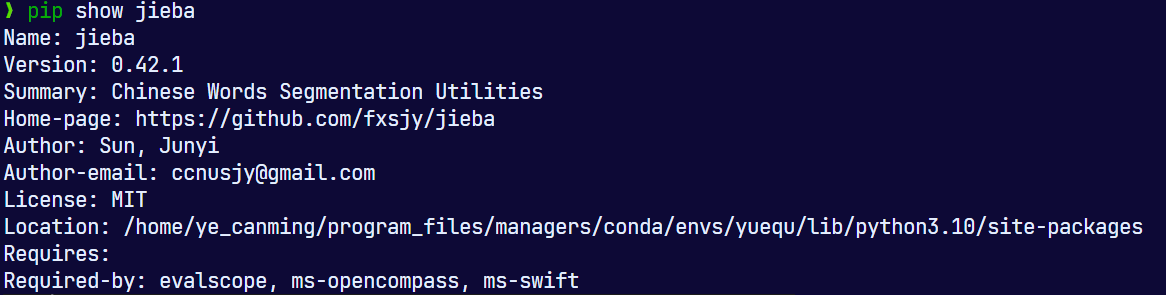

为了记录我们自己修改了哪些地方，使用git进行版本控制。

```bash
git init
git add .
git commit -m "init"
```

为了让老师给的代码更加规范，提高可读性，使用ruff进行格式化。

```bash
uv pip install ruff
ruff format
```

结合 DRY 软件工程原则，我们参考fastai的文档规范来对函数做注释，防止重复声明很多次类型（助教使用的doc string 风格，会重复声明很多次，不好维护）


## 4:1 划分数据集为训练集和验证集

注意到助教给出的main代码中已经有对应的实现，比如`main_cut.py`中
```python
# 训练集验证集划分
random.seed(19260817)
random.shuffle(corpus)
train_size = round(len(corpus) * 4 / 5)
train_set, valid_set = corpus[:train_size], corpus[train_size:]
print("Train:", len(train_set), ", Valid:", len(valid_set))
```
先对corpus这个list进行了打乱，然后取前4/5作为训练集，后1/5作为验证集。
我们也可以用sklearn去做这个事情，不过这里就不再赘述了。

## 分词算法的核心代码实现

首先我们阅读 `main_cut.py` 熟悉一下整体流程。

从import来看，我们需要实现这些函数才能跑通这个main。
```python
from util.cut_util import maximum_match_cut, get_final_result, jieba_cut, evaluate
```

具体而言，代码的流程为
- 预处理
    - 把文本文件当做是行的列表，每一行独立开来。
    - 使用 map 函数对每一行进行处理，仍然是行的列表，不过现在行是单词的列表。
        - 每一行用空格split为多个单词
        - 使用 `re.sub(r"^\[|/[a-zA-Z]+", "", item)` 
            - 正则表达式中 | 分开了左右两个表达式，表示或者的意思。
            - 右边是至少英语字母的字符串，左边是以[开头的字符串。
            - 使用 sub去除
        - 每一行当做了句子。
    - 训练集验证集划分，一个句子是一个样本。
    - 用训练集来构建词表
        - 记录单词的集合
        - 单词是字符串，对每一个字符串做 `lambda x: x[::-1]`, 获得字符串的逆序字符串的集合。
    - 让验证集符合评测的格式
        - 使用 `"".join` 把验证集的句子没有空格地拼起来
        - valid_label 记录验证集每一个样本每一个单词的开始和结束位置
- 我们写的分词算法
    - **调用 `maximum_match_cut` 进行正向和反向分词**
        - 这里使用到训练集学习到的词表
        - 反向匹配和正向匹配不需要修改内部函数的实现
        - 只需要把item（句子的单词的列表）`[::-1]` 同时使用反向词表。
        - 不过结果的index需要转换一下。
    - 调用 `get_final_result` 
- 结巴分词算法
- 评测效果



### 评价指标的实现

开尔文曾说，“如果你不能度量它，你就不能改进它。” 我认为实现 `evaluate` 函数是最重要的一步。

我们的输入是 "each tuple is an index pair indicating one parsed word"
表示这个word需要tuple，那就是开始和结束的index。
我们约定右边是开区间，左边是闭区间。

首先我们需要复习一下课件。

课件首先提到，计算准确性指标的基本单位分为词和句。
如果是按照句来算，那么完全正确分词的句子会被认为是正确的，不完全正确的句子会被认为是错误的。
如果是按照词来算，需要计量正确分隔的词的数量和总共的词的数量。

Precision是以predict出来的结果的单词数为基准，计算其中有多少是正确的。
recall则是以真实的单词数为基准，计算其中有多少被预测出来了。

这里其实有个问题课件没有说清楚，因为每一个句子（样本）的单词数量不一样多，所以按照词来算也有两种方式。
- 不管句子了，完全按照单词计算指标
- 每个句子内，按照单词计算指标，然后每个句子的指标求平均。

这里我们顺便复习一个概念，叫做`macro`和`micro`。
> 多分类中，macro auc是每个类别按照二分类（one vs rest）求auc，然后求平均。
> micro auc 是累计所有类别的 TP, FP , FN 的数量，计算整体的TPR和FPR。


我们扩展助教给的函数签名，在兼容以前API的情况下增加 `beta` 和 `macro_or_micro` 参数。

In [1]:
#| export
from typing import List, Tuple

def evaluate(
    prediction: List[List[Tuple[int, int]]],  # [sentence, word] -> [start, end]
    target: List[List[Tuple[int, int]]],  # [sentence, word] -> [start, end]
    macro_or_micro: bool = True,  # True for macro, False for micro
    beta:float = 1.0, # beta for f beta
) -> Tuple[float, float, float]: # precision, recall, f beta
    # Span-level metric calculation, return precision, recall, and f beta
    true_positives: List[int] = []  # 每一个句子计算 有多少个 正确
    positives: List[int] = []  # 预测了多少个东西
    real_positives: List[int] = []  # 实际有多少个东西
    for i in range(len(prediction)):
        pred = set(prediction[i])
        tar = set(target[i])
        true_positives.append(len(pred & tar))
        positives.append(len(pred))
        real_positives.append(len(tar))
    if macro_or_micro:
        # macro average
        # 每个句子单独求 P, R 然后求平均
        precision = sum(map(lambda i:true_positives[i]/positives[i] if positives[i] >0 else 0,
                             range(len(prediction)))) / len(prediction)
        recall = sum(map(lambda i:true_positives[i]/real_positives[i] if real_positives[i] >0 else 0
                         , range(len(prediction))) ) / len(prediction)
    else:
        # micro average
        # 求出单词级别的总体的 P, R
        precision = sum(true_positives) / sum(positives) if sum(positives) > 0 else 0
        recall = sum(true_positives) / sum(real_positives) if sum(real_positives) > 0 else 0
    f_beta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
    return precision, recall, f_beta


我们进行单元测试，在jupyter notebook中看看行不行。

In [2]:
predictions = [
    [(0, 1), (1, 2), (3,5)], # 第一个句子
    [(0, 2), (2, 3), (3,5)] # 第二个句子
]
targets = [[(0, 1), (1, 4), (4,5)], # 第二个第三个词分词歧义
           [(0, 3), (3,5)]] # 认为前面不需要分词
macro = evaluate(predictions, targets, True)
micro = evaluate(predictions, targets, False)
macro, micro

((0.3333333333333333, 0.41666666666666663, 0.3703703703703703),
 (0.3333333333333333, 0.4, 0.3636363636363636))

### 结巴分词的实现

参考官方文档 https://github.com/fxsjy/jieba

In [3]:
import jieba
jieba.tokenize?

Signature: jieba.tokenize(unicode_sentence, mode='default', HMM=True)
Docstring:
Tokenize a sentence and yields tuples of (word, start, end)

Parameter:
    - sentence: the str(unicode) to be segmented.
    - mode: "default" or "search", "search" is for finer segmentation.
    - HMM: whether to use the Hidden Markov Model.
File:      ~/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/jieba/__init__.py
Type:      method


助教给的`def jieba_cut(valid_text: List[str]):` 没有传入词表，为此，我们增加一个新的参数 `train_set`, 传入训练集，然后我们告诉结巴分词，这些词是我们的词表。

In [4]:
jieba.add_word?

Signature: jieba.add_word(word, freq=None, tag=None)
Docstring:
Add a word to dictionary.

freq and tag can be omitted, freq defaults to be a calculated value
that ensures the word can be cut out.
File:      ~/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/jieba/__init__.py
Type:      method

(word, start, end) 是三元组，不过助教的代码约定的是二元组 (start, end), 所以我们需要转换一下。

In [5]:
# | export
import jieba

from collections import Counter
def jieba_cut(
    valid_text: List[str], 
    train_set = None # 我们新增加的参数，让jieba可以优先使用训练集的词汇
) -> List[List[Tuple]]:  # jieba_result
    """use jieba to cut"""
    # 增加词库
    if train_set is not None:
        counter = Counter([word for sent in train_set for word in sent])
        for word, freq in counter.items():
            jieba.add_word(word, freq)
    # 分词
    return [
        [res[1:] for res in jieba.tokenize(text, "default", True)]
        for text in valid_text
    ]

In [6]:
# 单元测试一下
strs=["我来到北京清华大学","乒乓球拍卖完了","中国科学技术大学"]
jieba_cut(strs)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.520 seconds.
Prefix dict has been built successfully.


[[(0, 1), (1, 3), (3, 5), (5, 9)],
 [(0, 3), (3, 5), (5, 6), (6, 7)],
 [(0, 2), (2, 6), (6, 8)]]

现在注释掉双向匹配法部分的代码，可以运行 `main_cut.py` 了。

In [29]:
!python ./main_cut.py --jieba_method

Corpus Size: 19484
Corpus Samples: [['迈向', '充满', '希望', '的', '新', '世纪', '——', '一九九八年', '新年', '讲话', '（', '附', '图片', '１', '张', '）'], ['中共中央', '总书记', '、', '国家', '主席', '江', '泽民'], ['（', '一九九七年', '十二月', '三十一日', '）']]
Train: 15587 , Valid: 3897
Vocab Size: 49917
Valid Sample:
 钱其琛说，中国人民钦佩圣马力诺人民在经济建设方面取得的成就，赞赏圣马力诺奉行中立的外交政策，以及为促进和平、友谊和国际合作作出的积极贡献。 
 [(0, 1), (1, 3), (3, 4), (4, 5), (5, 7), (7, 9), (9, 11), (11, 15), (15, 17), (17, 18), (18, 20), (20, 22), (22, 24), (24, 26), (26, 27), (27, 29), (29, 30), (30, 32), (32, 36), (36, 38), (38, 40), (40, 41), (41, 43), (43, 45), (45, 46), (46, 48), (48, 49), (49, 51), (51, 53), (53, 54), (54, 56), (56, 57), (57, 59), (59, 61), (61, 63), (63, 64), (64, 66), (66, 68), (68, 69)]
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.550 seconds.
Prefix dict has been built successfully.
jieba分词(默认模式), precision=0.790231240479323, recall=0.7468986521286566, f1=0.7679541608322485, macro_or_micro=

可以看出，增加了训练集词库的效果反而不如默认分词效果，这可能是因为我们用户的词库太小了，结巴的词库经验更加丰富，词频信息比我们准确很多。

### 自己实现最大匹配法

#### 实现 前向匹配法 和 后向匹配法

复习老师的课件
![image.png](attachment:image.png)

简单来说，就是贪心，然后认为越长的词越好。
我个人认为 “max_size”其实没有意义，
首先这会让词库中比max_size长的词无法被匹配到，
相当于裁剪了词库，实际上本质就是找词库中能匹配得到的最长的词。
其实最快的实现就是用字典树，一直往下走，直到走不动为止。

In [9]:
#| export
def maximum_match_cut(
    text: str, # input text to be parsed
    vocab: set, # word set
    max_size: int = 4 # considered maximum length of words
) -> List[Tuple[int, int]]: # result, list of index pair indicating parsed words, e.g. [(0, 3), (3, 5), ...]
    """
    maximum matching algo
    """
    result = []
    left, right = 0, max_size
    while left < len(text): # 左边指针的左边是已经分词好的，右边是未分词的
        while right > left: # 从最大长度开始找，直到找到一个词
            current_str = text[left:right]
            if current_str in vocab:
                result.append((left, right))
                break # break 内循环
            right -= 1
        if right == left: # 如果找不到词，就把一个字当做一个词
            right = left + 1 
            result.append((left, right))
        # 现在已经有一个词了，更新左右指针，开始下一个词
        left = right
        right = left + max_size
        
    return result

In [26]:
with jieba.get_dict_file() as f:
    jieba_vocab = set()
    jieba_vocab_inverted = set()
    for line in f:
        word = line.split()[0]
        # print(type(word))
        # break
        word = word.decode("utf-8")
        jieba_vocab.add(word)
        jieba_vocab_inverted.add(word[::-1])
# jieba_vocab

In [27]:
text = strs[0]
text, maximum_match_cut(text, jieba_vocab), maximum_match_cut(text[::-1], jieba_vocab_inverted)

('我来到北京清华大学',
 [(0, 1), (1, 3), (3, 5), (5, 9)],
 [(0, 4), (4, 6), (6, 8), (8, 12)])

#### 实现 双向匹配法

根据课件，双向匹配法（Bi-direction Matching method）可以“比较MM法与RMM法的分词结果，从而决定正确的分词”

这对应于我们代码中的 `def get_final_result(backward_result: List[Tuple], forward_result: List[Tuple]):`

但是老师课件没有详细描述具体怎么操作，我们来查阅一下资料和文献。

根据 https://www.cnblogs.com/Denise-hzf/p/6123940.html ，需要比较两种切分结果，若一致则直接输出；若不一致，则通过预设规则选择最优解。具体的预设规则是什么呢？

根据教材《自然语言处理导论》（https://chengzhaoxi.xyz/download/pdf/book/%E8%87%AA%E7%84%B6%E8%AF%AD%E8%A8%80%E5%A4%84%E7%90%86%E5%85%A5%E9%97%A8.pdf），首先原理上，孙茂松教授认为逆向匹配的正确率更高，不过也有两种方法都无法消除歧义的情况；先不考虑两种都错了，可以假设其中有一个对了。

具体的规则集可以是
1. 两种结果一致，直接输出
2. 如果单词数量不同，选择单词数量少的
3. 如果单词数量相同，选择单字成词最少得那个
4. 如果还相同，选择逆向匹配的结果。

其中规则三石因为汉语中但自此的数量比非单字词要少很多（很神奇哦）。



In [ ]:
#| export
def count_single_words(result: List[Tuple[int, int]]) -> int:
    """
    count single words in the result
    """
    return sum(1 for start, end in result if end - start == 1)

from collections import Counter
running_stats = Counter()

def get_final_result(
    backward_result: List[Tuple], forward_result: List[Tuple]
) -> List[Tuple]:  # result
    """
    return final result given backward matching result and forward matching result
    """
    # 如果两个结果一样，就返回
    if backward_result == forward_result: # python的list == 是正确的。
        return backward_result
    else:
        results = [backward_result, forward_result]
        idx = min(
            (0, 1),  
            key=lambda idx: (
                len(results[idx]),  # 先看分词数量，越少越好
                count_single_words(results[idx]),  # 再看单字词数量，越少越好
                idx # 最后看元组中的顺序，
            ),
        )
        running_stats.update([idx])
        return results[idx]


现在我们可以运行 `main_cut.py` 了。

In [32]:
!python ./main_cut.py --my_method

Corpus Size: 19484
Corpus Samples: [['迈向', '充满', '希望', '的', '新', '世纪', '——', '一九九八年', '新年', '讲话', '（', '附', '图片', '１', '张', '）'], ['中共中央', '总书记', '、', '国家', '主席', '江', '泽民'], ['（', '一九九七年', '十二月', '三十一日', '）']]
Train: 15587 , Valid: 3897
Vocab Size: 49917
Valid Sample:
 钱其琛说，中国人民钦佩圣马力诺人民在经济建设方面取得的成就，赞赏圣马力诺奉行中立的外交政策，以及为促进和平、友谊和国际合作作出的积极贡献。 
 [(0, 1), (1, 3), (3, 4), (4, 5), (5, 7), (7, 9), (9, 11), (11, 15), (15, 17), (17, 18), (18, 20), (20, 22), (22, 24), (24, 26), (26, 27), (27, 29), (29, 30), (30, 32), (32, 36), (36, 38), (38, 40), (40, 41), (41, 43), (43, 45), (45, 46), (46, 48), (48, 49), (49, 51), (51, 53), (53, 54), (54, 56), (56, 57), (57, 59), (59, 61), (61, 63), (63, 64), (64, 66), (66, 68), (68, 69)]
100%|████████████████████████████████████| 3897/3897 [00:00<00:00, 12758.89it/s]
Result Sample: [(-3, 1), (1, 3), (3, 4), (4, 5), (5, 7), (7, 9), (9, 11), (11, 15), (15, 17), (17, 18), (18, 20), (20, 22), (22, 24), (24, 26), (26, 27), (27, 29), (29, 30), (30, 32), (32, 36), (36,

对比上面 `jieba_cut` 的结果，我们发现，我们实现的双向匹配法的效果比jieba好。
特别是对于micro指标，差距非常显著，体现了我们方法的有效性。
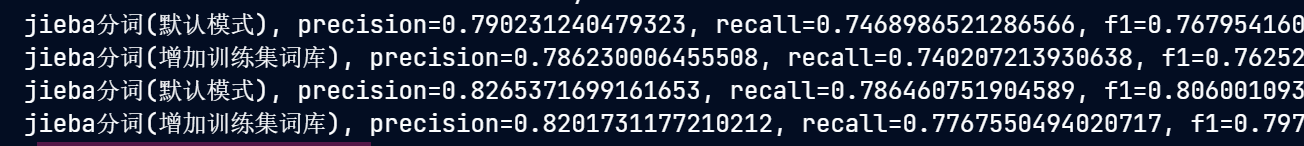

另外一个值得注意的是双向匹配法确实发挥了作用，使用了2169次反向匹配，1726次正向匹配，这个是比较均衡的，说明确实有一些句子是正向匹配好的，有一些句子是逆向匹配好的。

## 词性标注算法的核心代码实现

我们上面已经成功实现了分词算法，